### Can attention help with discovering contemporaneous relationships?
- NAVAR vs TAMCaD on many (5, 300, 5) with contemporaneous relationships, receptive field of 6 (such that complexity is non-issue)
- Compare average performance (AUROC), where scores are computed from a temporal matrix. NAVAR should use a sliding window.
- Show plot of contemporaneous timeline.
- Compare with continuous regularization loss
- Show plot of contemporaneous uncertainty.

In [1]:
import sys
sys.path.append("../../") # if running from this folder
import torch
from matplotlib import pyplot as plt
import pandas as pd
from src.models import NAVAR, NAVAR_UA, TAMCaD, TAMCaD_UA
from src.training import train_model, train_test_split
from src.eval import plot_contemporaneous_relationships, plot_all_contemporaneous_relationships
from tqdm.notebook import trange, tqdm

In [2]:
dataset = torch.load('../data_generation/synthetic_contemporaneous_N-4_T-2000_K-5.pt')
print({k: v.shape if isinstance(v, torch.Tensor) else v for k, v in dataset.items()})

model_variations = {
    'NAVAR': {'model_type': NAVAR, 'lambda1': 0.3, 'hidden_dim': 16, 'weight_sharing': False, 'epochs': 400, 'dropout': 0.2},
    'NAVAR_UA': {'model_type': NAVAR_UA, 'beta': 0.3,'n_ensembles': 30, 'lambda1': 0.1, 'hidden_dim': 32, 'weight_sharing': True, 'epochs': 600, 'dropout': 0.2},
    'TAMCaD': {'model_type': TAMCaD, 'gamma': 0.005, 'hidden_dim': 24, 'weight_sharing': True, 'epochs': 600, 'dropout': 0.2},
    'TAMCaD_UA': {'model_type': TAMCaD_UA, 'gamma': 0.001, 'lambda1':0.1, 'n_ensembles': 30, 'hidden_dim': 32, 'weight_sharing': True, 'epochs': 600, 'dropout': 0.2},
}
params = {
    'experiment_name': 'contemporaneous_relationships',
    'lr': 1e-3,
    'weight_decay': 1e-8,
    'test_size': 0.0,
    'kernel_size': 2,
    'n_blocks': 2,
    'n_layers': 2,
    'use_positional_embedding': True
}
#plt.plot(dataset['data'][0].t())
#plt.show()

all_results = {}

for id, model_params in model_variations.items():
    print('Process', id)
    all_results[id] = []
    for i in range(1): #dataset['data'].size(0)):
        data_subset = {
            'name': 'synthetic_contemporaneous_N-4_T-1000_K-5', 
            'data': dataset['data'][i:i+1], 
            'data_noise_adjusted': dataset['data_noise_adjusted'][i:i+1], 
            'ground_truth': dataset['ground_truth'][i],
            'temporal_matrix': True
        }
        all_results[id].append(train_model(
            experiment_run=id,
            dataset=data_subset,
            **model_params,
            **params
        ))



{'data': torch.Size([1, 4, 2000]), 'data_noise_adjusted': torch.Size([1, 4, 2000]), 'ground_truth': torch.Size([1, 4, 4, 2000])}
Process NAVAR


train_loss=0.85, train_noise=0.69, train_AUROC=0.98: 100%|███████████████████████████| 400/400 [00:09<00:00, 43.18it/s]


Process NAVAR_UA


train_loss=0.41, train_noise=0.53, train_AUROC=0.99, train_soft_=0.94: 100%|█████████| 600/600 [00:41<00:00, 14.55it/s]


Process TAMCaD


train_loss=0.72, train_noise=0.54, train_AUROC=0.91: 100%|███████████████████████████| 600/600 [00:11<00:00, 52.39it/s]


Process TAMCaD_UA


train_loss=0.70, train_noise=0.42, train_AUROC=0.93, train_soft_=0.91: 100%|█████████| 600/600 [00:45<00:00, 13.11it/s]


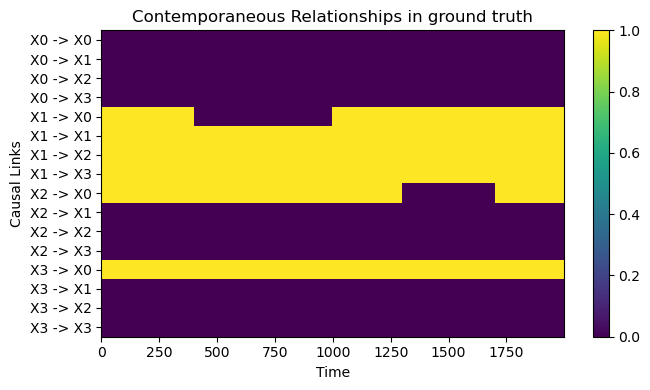

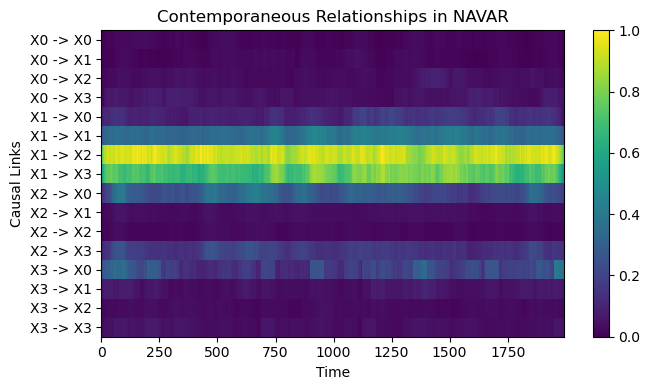

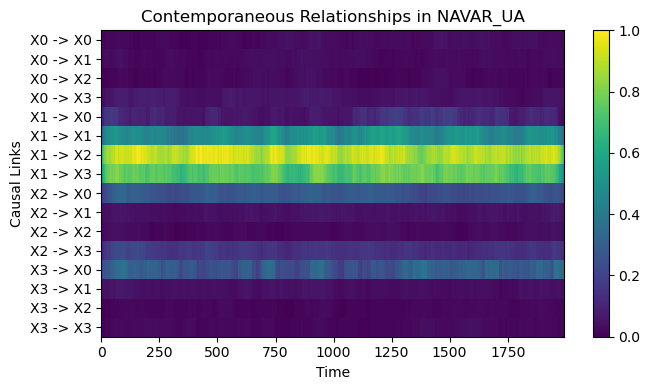

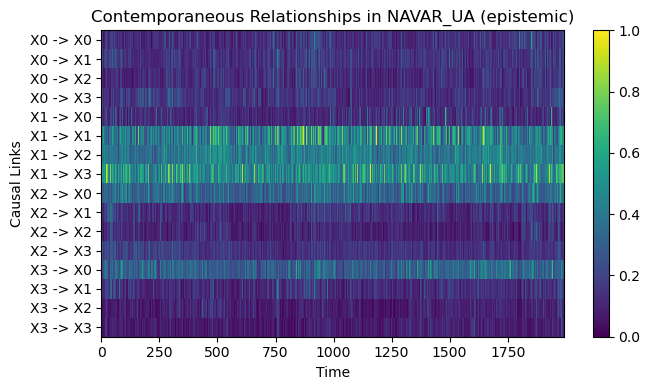

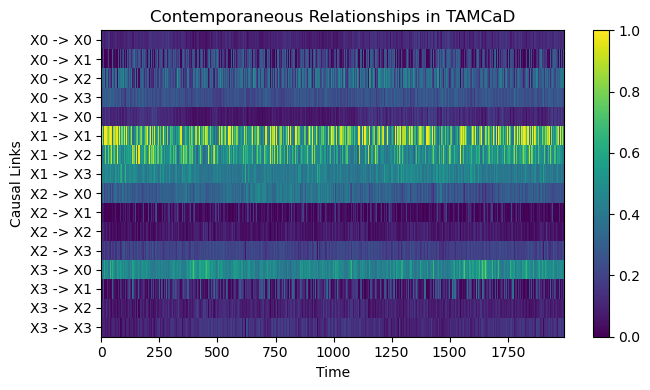

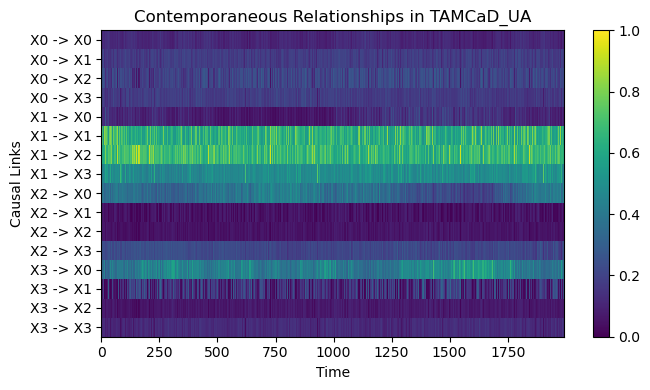

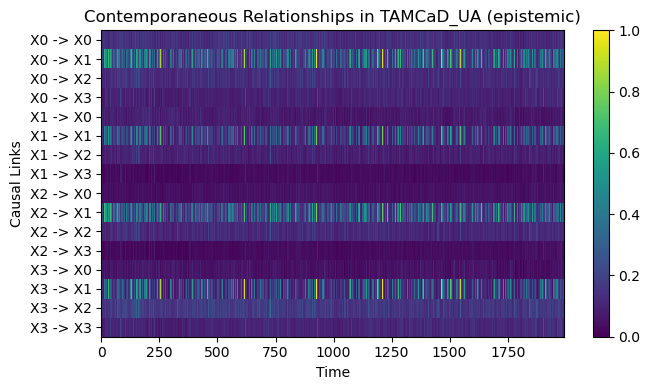

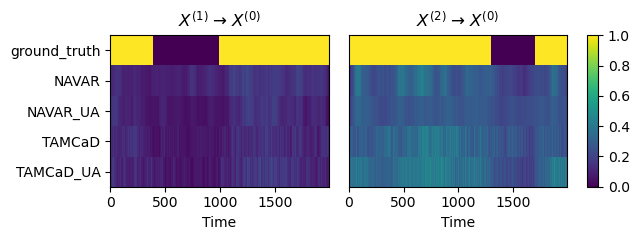

In [3]:
plot_all_contemporaneous_relationships(dataset['ground_truth'][i], 'ground truth')
plt.show()

for model_name, result in all_results.items():
    if 'UA' in model_name:
        matrix = all_results[model_name][0]['train_artifacts']['matrix_temporal']
        plot_all_contemporaneous_relationships(matrix, model_name)
        if 'NAVAR' in model_name:
            matrix_ep = all_results[model_name][0]['train_artifacts']['contributions_ep']
        else:
            matrix_ep = all_results[model_name][0]['train_artifacts']['attention_logits_ep']
        plot_all_contemporaneous_relationships(matrix_ep, model_name + ' (epistemic)')
    else:
        matrix = all_results[model_name][0]['train_artifacts']['matrix']
        plot_all_contemporaneous_relationships(matrix, model_name)
    #plt.show()


all_matrices = []
for model_name, result in all_results.items():
    result = result[0]
    if 'UA' in model_name:
        all_matrices.append(result['train_artifacts']['matrix_temporal'])
    else:
        all_matrices.append(result['train_artifacts']['matrix'])

new_len = all_matrices[0].size(-1)
all_matrices = [dataset['ground_truth'][i, ..., -new_len:]] + all_matrices
names = ['ground_truth'] + list(all_results.keys())

plot_contemporaneous_relationships(*all_matrices, causal_links=[(1,0), (2,0)], names=names, smooth=1.0)
plt.savefig('contemporaneous.png')
plt.show()

In [6]:
table_data = []

# Iterate through each model's results
for model_name, result in all_results.items():
    result = result[0]
    # Extract desired metrics
    loss = round(result['train_metrics']['loss'][1][-1].item(), 3)
    num_params = result['model_params']['n_params']
    training_time_per_epoch = round(1000 * result['model_params']['training_time_per_epoch'], 1)
    receptive_field = result['model_params']['receptive_field']
    auroc = round(result['train_metrics']['AUROC'][1][-1].item(), 2)
    best_auroc = round(result['train_metrics']['AUROC'][1].max().item(), 2)
    
    # Add a row to the table data
    table_data.append({
        "Model": model_name,
        "AUROC": auroc,
        "AUROC (best)": best_auroc,
        "Loss": loss,
        "n_param": num_params,
        "Time per Epoch (ms)": training_time_per_epoch,
        "Receptive Field": receptive_field
    })

results_df = pd.DataFrame(table_data)

results_df.set_index("Model", inplace=True)

results_df.sort_values('AUROC (best)')

,AUROC,AUROC (best),Loss,n_param,Time per Epoch (ms),Receptive Field
Model,,,,,,
TAMCaD,0.91,0.93,0.720,11636,19.1,7
TAMCaD_UA,0.93,0.95,0.702,496824,76.1,7
NAVAR,0.98,0.99,0.853,7060,17.3,7
NAVAR_UA,0.99,0.99,0.413,304824,68.5,7


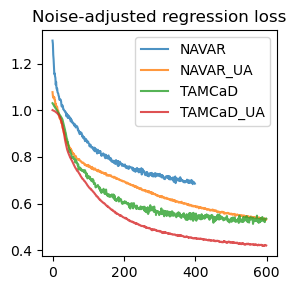

In [28]:
def plot_regression_noise_loss():
    fig, axes = plt.subplots(figsize=(3, 3))
    # Iterate through each model
    for i, (model_name, result) in enumerate(all_results.items()):
        n_ax = 0 if 'NAVAR' in model_name else 1
        tag = 'NAVAR' if 'NAVAR' in model_name else 'TAMCaD'
        result = result[0]
        plt.plot(*result['train_metrics']['noise_adjusted_regression_loss'], label=model_name, alpha=0.8)
    plt.title('Noise-adjusted regression loss')
        #axes[n_ax].xlim(40, 1200)
        #axes[n_ax].ylim(0.02, 0.08)
    plt.legend()
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Display the plot
    plt.savefig('noise_regression_losses.png')
    plt.show()
plot_regression_noise_loss()

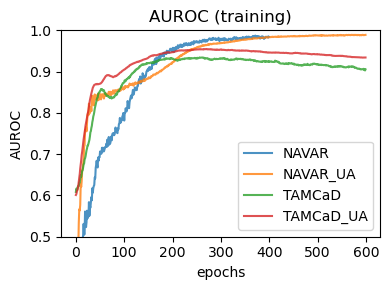

In [27]:
def plot_auroc():

    fig, axes = plt.subplots(figsize=(4, 3))

    # Iterate through each model
    for i, (model_name, result) in enumerate(all_results.items()):
        n_ax = 0 if 'NAVAR' in model_name else 1
        tag = 'NAVAR' if 'NAVAR' in model_name else 'TAMCaD'
        result = result[0]
        plt.plot(*result['train_metrics']['AUROC'], label=model_name , alpha=0.8)
        
        #axes[n_ax].set_xlim(40, 1200)
        plt.ylim(0.5, 1.0)
        
    plt.legend()
    plt.title('AUROC (training)')
    plt.ylabel('AUROC')
    plt.xlabel('epochs')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Display the plot
    plt.savefig('plot_auroc.png')
    plt.show()
plot_auroc()